In [1]:
# Clear memory
%reset -f

In [2]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import ipywidgets
ipywidgets.Widget.close_all()

import SimpleITK
import datetime
import gc # Garbage collected
import numpy as np
import sys, os
import time
import tifffile
import matplotlib.pyplot as plt
import scipy
from tkinter import Tk
from tkinter.filedialog import askopenfilename, askopenfilenames, askdirectory
import torch
import skimage
from skimage import measure
from skimage.morphology import skeletonize
import pickle
import networkx as nx
import sknw # https://github.com/Image-Py/sknw

this_path = os.getcwd()
print(this_path)


import h5py
# import File
from scripts import *
import wrapper_ASTRA

/global/u2/e/eboigne/tomoTools_als832/tomoTools


In [3]:
path_save = '/global/homes/e/eboigne/cfs_als/2022_wood/'

# case = 'run21_oak_lowHeat'
# case = 'run23_walnut_lowHeat'
case = 'run24_birch_lowHeat'
# case = 'run26_birch_highHeat'

voxel_size = 3.24*2 # [microns]

list_cases_folder_name = sorted([e for e in os.listdir(path_save+case) if not 'probe' in e and not '.tif' in e and not '.pickle' in e])
run = case[3:5]+'_Sample'
list_cases_h5 = sorted([e for e in os.listdir(path_save) if '.h5' in e and run in e])

print(list_cases_folder_name)

['01', '02', '03', '04', '05', '06', '07', '08a', '08b', '09a', '09b', '10a', '10b', '11a', '11b', '12a', '12b', '13a', '13b', '14a', '14b', '15a', '15b', '16a', '16b', '17a', '17b', '18a', '18b', '19a', '19b', '20a', '20b', '21a', '21b', '22', '23', '24']


In [4]:
ind_slice = 250

slices = []
for ind_case, this_case in enumerate(list_cases_folder_name[:]):
    slices.append(File(path_save+case+'/'+this_case+'/b_movingRegisteredToStatic/').read(ind_slice))
    print(ind_case, this_case)

slices = np.array(slices)
print(slices.shape)
File(path_save+case+'/probe_slice_'+str(ind_slice).zfill(4)).saveTiffStack(slices)

0 01
1 02
2 03
3 04
4 05
5 06
6 07
7 08a
8 08b
9 09a
10 09b
11 10a
12 10b
13 11a
14 11b
15 12a
16 12b
17 13a
18 13b
19 14a
20 14b
21 15a
22 15b
23 16a
24 16b
25 17a
26 17b
27 18a
28 18b
29 19a
30 19b
31 20a
32 20b
33 21a
34 21b
35 22
36 23
37 24
(38, 1280, 1280)


In [5]:
c = []
for this_case in enumerate(list_cases_h5):
    c.append(this_case[1][35:37])

t = []

list_scans = []

for this_case in enumerate(c):
    if str(this_case[1]) in list_cases_folder_name:
        cc = list_cases_h5[this_case[0]][9:15]
        h = cc[0:2]
        m = cc[2:4]
        s = cc[4:]
        ts = float(int(h)*3600+int(m)*60+int(s))
        t.append(ts) #c
        print(len(t), this_case, 'c', ts)
    else:
        cc = list_cases_h5[this_case[0]][9:15]
        h = cc[0:2]
        m = cc[2:4]
        s = cc[4:]
        ts0 = float(int(h)*3600+int(m)*60+int(s))
        t.append(ts0) #a
        ts1 = 26.26 + ts0
        t.append(ts1) #b
        print(len(t), this_case, 'a/b', ts0 ,ts1)

scan_times = np.array(t) - t[0]

assert(len(list_cases_folder_name) ==len(scan_times)), 'Wrong sizes'

for ind_scan,scan_time in enumerate(scan_times):
    this_scan = Data()
    this_scan.scan_time = scan_time
    this_scan.folder_name = list_cases_folder_name[ind_scan]
    this_scan.full_path = path_save+case+'/'+this_scan.folder_name
    list_scans.append(this_scan)

1 (0, '01') c 62666.0
2 (1, '02') c 62972.0
3 (2, '03') c 63291.0
4 (3, '04') c 63812.0
5 (4, '05') c 64069.0
6 (5, '06') c 64249.0
7 (6, '07') c 64434.0
9 (7, '08') a/b 64616.0 64642.26
11 (8, '09') a/b 64813.0 64839.26
13 (9, '10') a/b 65005.0 65031.26
15 (10, '11') a/b 65187.0 65213.26
17 (11, '12') a/b 65369.0 65395.26
19 (12, '13') a/b 65553.0 65579.26
21 (13, '14') a/b 65736.0 65762.26
23 (14, '15') a/b 65932.0 65958.26
25 (15, '16') a/b 66121.0 66147.26
27 (16, '17') a/b 66304.0 66330.26
29 (17, '18') a/b 66488.0 66514.26
31 (18, '19') a/b 66673.0 66699.26
33 (19, '20') a/b 66864.0 66890.26
35 (20, '21') a/b 67049.0 67075.26
36 (21, '22') c 67247.0
37 (22, '23') c 67552.0
38 (23, '24') c 67860.0


In [6]:
def compute_mask_solid(this_scan, force_redo = False):

    if force_redo or not 'b_movingRegisteredToStatic_maskSolid' in os.listdir(this_scan.full_path):

        # Loading data
        tic = time.time()
        data = File(path_save+case+'/'+this_scan.folder_name+'/b_movingRegisteredToStatic/').readAll()
        print('\tLoading data took: '+str(time.time()-tic))

        threshold = 0.05 # Linear attenuation threshold [/cm], gas to wood
        threshold_needle = 4.0 # Linear attenuation threshold [/cm]
        mask_growth_needle = 10 # Grow the mask obtained using threshold_needle with this amount of pixels
        mask_enclosing_circle = tifffile.imread(path_save+case+'/maskEnclosingCircle.tif') > 0
        bin_factor_dilatation = 1 # Binning before smoothing, as an option to speed things up for large kernels
        filter_half_width = 3 # After binning (equal to sigma for gaussian filter)

        kernel = custom_3d_gaussian_filter(filter_half_width)

        if bin_factor_dilatation > 1:
            data_smoothed = fast_pytorch_bin_3d(data,bin_factor_dilatation, chunk_size = 71)
        else:
            data_smoothed = data

        data_smoothed = apply_3d_image_processing_on_subvolumes(data_smoothed, fast_pytorch_convolution, kernel_array = kernel, chunk_size_max = (500, 500, 500), overlap = 3*filter_half_width)

        if bin_factor_dilatation > 1:
            data_smoothed = skimage.transform.rescale(data_smoothed, bin_factor_dilatation, multichannel=False)

        mask_needle = data_smoothed > threshold_needle
        mask_needle = apply_3d_image_processing_on_subvolumes(mask_needle, fast_pytorch_mask_dilation, chunk_size_max = (500, 500, 500), overlap = mask_growth_needle, radius = mask_growth_needle)

        mask_solid = data_smoothed > threshold
        mask_solid[mask_needle] = False

        for ind, slice in enumerate(mask_solid):
            slice[~mask_enclosing_circle] = False
            mask_solid[ind] = slice

        File(this_scan.full_path+'/b_movingRegisteredToStatic_maskSolid').saveTiffStack(mask_solid, type = 'bool')
    else:
        print('\tRe-loading mask solid')
        mask_solid = File(this_scan.full_path+'/b_movingRegisteredToStatic_maskSolid').readAll()

    return(mask_solid.astype('bool'))

def close_mask_solid(this_scan, mask_solid, force_redo = False):

    if force_redo or not 'b_movingRegisteredToStatic_maskSolidClosed' in os.listdir(this_scan.full_path):

        filter_half_width = 12
        chunk_size = (500, 500, 500)

        # Morphological closing: closing the pores
        structure = custom_3d_kernel_sphere(filter_half_width)
        mask_solid_dilated = apply_3d_image_processing_on_subvolumes(mask_solid, fast_pytorch_mask_dilation, chunk_size_max = chunk_size, overlap = filter_half_width, radius = filter_half_width)
        mask_solid_closed = ~apply_3d_image_processing_on_subvolumes(~mask_solid_dilated, fast_pytorch_mask_dilation, chunk_size_max = chunk_size, overlap = filter_half_width, radius = filter_half_width)

        File(this_scan.full_path+'/b_movingRegisteredToStatic_maskSolidClosed').saveTiffStack(mask_solid_closed, type = 'bool')

    else:
        print('\tRe-loading mask solid closed')
        mask_solid_closed = File(this_scan.full_path+'/b_movingRegisteredToStatic_maskSolidClosed').readAll()

    return(mask_solid_closed.astype('bool'))

def compute_height(properties):
    for prop in properties:
        bbox = prop.bbox
        prop.height = bbox[3]-bbox[0] # Along z, in pixels
    return(properties)

def compute_equivalent_cylinder_diameters(properties):
    for prop in properties:
        equivalent_cylinder_cross_section = prop.area / prop.height
        prop.equivalent_cylinder_diameter = np.sqrt(4*equivalent_cylinder_cross_section/np.pi) * voxel_size
    return(properties)

def get_path_length(graph, path):
    this_sum=0
    for i in range(len(path)-1):
        this_sum += graph.get_edge_data(path[i], path[i+1])['weight']
    return(this_sum)

def longest_simple_path(graph, source, target):
    longest_path = None
    longest_path_length = 0
    for path in nx.all_simple_paths(graph, source=source, target=target):
        path_length = get_path_length(graph,path)
        if path_length > longest_path_length:
            longest_path_length = path_length
            longest_path = path
    return longest_path, longest_path_length

def find_longest_subgraph_from_ends(graph, bbox):

    ind_end_nodes = [x for x in graph.nodes if graph.degree(x) == 1]
    ind_end_bottom = [x for x in ind_end_nodes if graph.nodes[x]['o'][0] - bbox[0] <=  bbox[3] - graph.nodes[x]['o'][0]]
    ind_end_top = [x for x in ind_end_nodes if not x in ind_end_bottom]

    longest_path_subgraph = None
    longest_path_length = 0
    longest_path = []
    for ind_bot in ind_end_bottom:
        for ind_top in ind_end_top:
            this_longest_path, this_longest_path_length = longest_simple_path(graph, source=ind_bot, target=ind_top)
            this_longest_path_subgraph = graph.subgraph(this_longest_path)

            if this_longest_path_length > longest_path_length:
                longest_path_length = this_longest_path_length
                longest_path = this_longest_path
                longest_path_subgraph = this_longest_path_subgraph

    return(longest_path_subgraph, longest_path, longest_path_length)

def compute_tortuosity(skeleton_properties):

    for ind_pore in range(len(skeleton_properties)):
        bbox = skeleton_properties[ind_pore].bbox
        graph = sknw.build_sknw(skeleton_properties[ind_pore].image, multi=False, iso=False, ring=False, full=True)
        longest_path_subgraph, longest_path, longest_path_length = find_longest_subgraph_from_ends(graph, bbox)

        if longest_path_length == 0:
            longest_path_length = np.nan

        skeleton_properties[ind_pore].length_skeleton = longest_path_length
        skeleton_properties[ind_pore].longest_path = longest_path
        # skeleton_properties[ind_pore].longest_path_subgraph = longest_path_subgraph
        skeleton_properties[ind_pore].tortuosity = longest_path_length / skeleton_properties[ind_pore].height

        # print(ind_pore, longest_path_length, skeleton_properties[ind_pore].tortuosity)
    return(skeleton_properties)

def compute_skeleton(this_scan, mask_pores, force_redo = False):

    if force_redo or not 'b_movingRegisteredToStatic_maskPores_skeleton' in os.listdir(this_scan.full_path):
        skeleton = skeletonize(mask_pores)
        File(this_scan.full_path+'/b_movingRegisteredToStatic_maskPores_skeleton').saveTiffStack(skeleton, type = 'bool')
    else:
        print('\tRe-loading skeleton')
        skeleton = File(this_scan.full_path+'/b_movingRegisteredToStatic_maskPores_skeleton').readAll()
    return(skeleton)


In [22]:
with open(path_save+case+'/post_pro_data.pickle', 'rb') as handle:
    list_scans = pickle.load(handle)

print(list_scans[6].folder_name)

07


In [23]:
# Re-load scan data
with open(path_save+case+'/post_pro_data.pickle', 'rb') as handle:
    list_scans = pickle.load(handle)

nb_scans = len(list_scans)
force_redo = False

for ind_scan,this_scan in enumerate(list_scans[6:7]):

    print('Running scan #'+str(ind_scan)+'/'+str(nb_scans)+' - '+this_scan.folder_name)

    # Loading data and computing mask solid
    mask_solid = compute_mask_solid(this_scan, force_redo = force_redo)

    # Crop mask solid
    ind_bottom = 100
    ind_top = 610
    mask_solid[:ind_bottom] = False
    mask_solid[ind_top:] = False

    # Close mask_solid and compute porosity
    print('\tClosing mask solid')
    mask_solid_closed = close_mask_solid(this_scan, mask_solid, force_redo = force_redo)

    # Compute porosity
    this_scan.porosity = 1 - np.sum(mask_solid.flatten()) / np.sum(mask_solid_closed.flatten())

    # Analyze pore structure
    mask_pores = mask_solid_closed * (~mask_solid)
    tic = time.time()
    lab = measure.label(mask_pores)
    properties = np.array(measure.regionprops(lab))
    print('\tParticle identification and analysis took: '+str(time.time()-tic))

    # Cleaning up pores
    properties = compute_height(properties)
    areas = np.array([prop.area for prop in properties])
    height = np.array([prop.height for prop in properties])
    this_scan.ind_properties_cleaned = np.where((areas>500) * (areas < 300000) * (height > 100))[0]
    properties_cleaned = properties[this_scan.ind_properties_cleaned]

    # Compute equivalent cylinder diameters
    properties_cleaned = compute_equivalent_cylinder_diameters(properties_cleaned)
    this_scan.nb_pores = len(properties_cleaned)
    # this_scan.pore_properties = properties_cleaned # Don't save this, otherwise pickle too heavy (image data stored)

    # Build and analyze skeleton for tortuosity
    tic = time.time()
    skeleton = compute_skeleton(this_scan, mask_pores, force_redo = force_redo)
    skeleton_lab = measure.label(skeleton)
    skeleton_properties = measure.regionprops(skeleton_lab)
    print('\tSkeletonize and analysis took: '+str(time.time()-tic))

    # Extract which pores to keep from skeleton
    skeleton_properties = compute_height(skeleton_properties)
    skeleton_areas = np.array([prop.area for prop in skeleton_properties])
    skeleton_height = np.array([prop.height for prop in skeleton_properties])
    this_scan.skeleton_ind_properties_cleaned = np.where((skeleton_areas>50) * (skeleton_areas < 1000) * (skeleton_height > 100))[0]

    # Compute tortuosity for each pore
    skeleton_properties_cleaned = compute_tortuosity(np.array(skeleton_properties)[this_scan.skeleton_ind_properties_cleaned])

    # Save relevant pore & skeleton properties
    this_scan.areas = [prop.area for prop in properties_cleaned]
    this_scan.equivalent_cylinder_diameters = [prop.equivalent_cylinder_diameter for prop in properties_cleaned]
    this_scan.heights = [prop.height for prop in properties_cleaned]
    this_scan.skeleton_pore_path_length = [prop.length_skeleton for prop in skeleton_properties_cleaned]
    this_scan.tortuosity = [prop.tortuosity for prop in skeleton_properties_cleaned if not np.isnan(prop.tortuosity)]

    # Update save of scan data
    print('\tUpdating save pickle')
    with open(path_save+case+'/post_pro_data.pickle', 'wb') as handle:
        pickle.dump(list_scans, handle)

print('Done')

Running scan #0/38 - 07
	Loading data took: 44.93602132797241
	 Processing 18 chunks of size [349 426 426] .................. Done
	 Processing 18 chunks of size [349 426 426] .................. Done
	Closing mask solid
	 Processing 18 chunks of size [349 426 426] .................. Done
	 Processing 18 chunks of size [349 426 426] .................. Done
	Particle identification and analysis took: 14.394068717956543
	Skeletonize and analysis took: 97.03547191619873
	Updating save pickle
Done


In [10]:
with open(path_save+case+'/post_pro_data.pickle', 'rb') as handle:
    list_scans = pickle.load(handle)

In [11]:
ind_scan = 0

print(list_scans[ind_scan].porosity)
print(list_scans[ind_scan].nb_pores)


0.15787853881702962
677


In [154]:
def smooth_histogram_curve(bin_edges, bin_values, N):
    bin_center = 0.5 * (bin_edges[:-1]+bin_edges[1:])
    n_bins = len(bin_edges)

    new_bins = np.linspace(bin_edges[0], bin_edges[-1], n_bins * N)
    new_bins_c = 0.5 * (new_bins[:-1]+new_bins[1:])
    new_bin_values = np.interp(new_bins_c, bin_center, bin_values)

    new_bins_diff = new_bins[1:] - new_bins[:-1]
    new_bin_values /= np.sum(new_bin_values * new_bins_diff)

    print(new_bins.shape)
    print(new_bin_values.shape)

    return(new_bins, new_bin_values)


def moving_avg(x, N):

    ones = np.ones([N,])
    ones /= ones.sum()
    return(np.convolve(x, ones, 'same'))


(45,)
(44,)
(45,)
(44,)
(45,)
(44,)
(45,)
(44,)
(45,)
(44,)
(45,)
(44,)


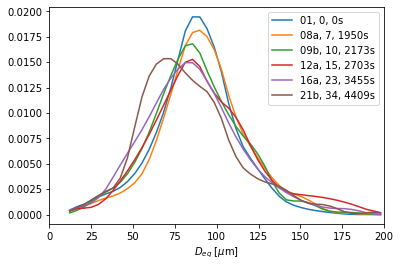

In [180]:
ind_to_show = range(38)
ind_to_show = [0, 7, 10, 15, 23, 37-3]

# ind_to_show = [34, 35, 36, 37]
# ind_to_show = [1,]
nb_bins = 15
diameter_hist_bin = np.linspace(10, 200, nb_bins)

N_smoothing = 3

for ind_scan in ind_to_show:

    diameter_hist, _ = np.histogram(list_scans[ind_scan].equivalent_cylinder_diameters, bins = diameter_hist_bin)
    # diameter_hist_bin_c = 0.5 * (diameter_hist_bin[:-1]+diameter_hist_bin[1:])

    bin_smoothed, bin_smoothed_values = smooth_histogram_curve(diameter_hist_bin, diameter_hist, N_smoothing)
    bin_smoothed_c = 0.5 * (bin_smoothed[:-1]+bin_smoothed[1:])

    bin_smoothed_values = moving_avg(bin_smoothed_values, N_smoothing)

    plt.plot(bin_smoothed_c, bin_smoothed_values, label=str(list_scans[ind_scan].folder_name)+', '+str(ind_scan)+', '+str(int(list_scans[ind_scan].scan_time))+'s')
plt.xlabel('$D_{eq}$ [$\mu$m]')
plt.xlim(0, 200)
plt.legend()




In [12]:
# print(properties[ind_properties_cleaned[ind_pore]].axis_major_length)
# print(properties[ind_properties_cleaned[ind_pore]].axis_minor_length)
# print(properties[ind_properties_cleaned[ind_pore]].inertia_tensor)
# print(properties[ind_properties_cleaned[ind_pore]].inertia_tensor_eigvals)


#
# print(np.where(tortuosity>2.5))
#
# ind_skeleton = 2
#
# print(skeleton_properties[skeleton_ind_properties_cleaned[ind_skeleton]].tortuosity)
#
# mask_ind_skeleton = (lab==skeleton_properties[ind_properties_cleaned[ind_skeleton]].label) > 0
# File(path_save+case+'/'+scan_to_test+'/b_movingRegisteredToStatic_maskPores_skeleton_checkOne').saveTiffStack(mask_ind_skeleton[::10])

In [44]:
nb_bins = 60
tortuosity_hist_bin = np.linspace(1.0, 2.0, nb_bins)

np.nanmax(list_scans[10].tortuosity)

1.8353996929719216

1.2139973972650882
1.2065241224140635
1.2095159749910669
1.2131388351257781
1.2109525664263303
1.2059537915230425
1.2145099478198975
1.2103313271625769
1.2137679197861118
nan
1.2358959699865097
1.2556142978174902
1.275178862259069
1.2418689743175237
1.2410810326846606
1.2546265950850102
1.2349527441512664
1.2637298461655946
1.2342819202623916


/global/homes/e/eboigne/local/miniconda3/envs/als/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


Text(0.5, 0, 'Tortuosity')

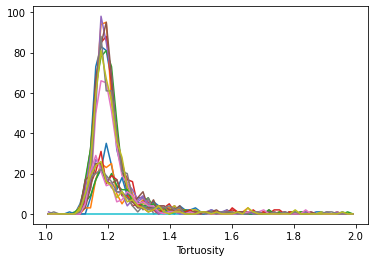

In [45]:
for ind_scan in range(19):
    tortuosity_hist, _ = np.histogram(list_scans[ind_scan].tortuosity, bins = tortuosity_hist_bin)
    tortuosity_hist_bin_c = 0.5 * (tortuosity_hist_bin[:-1]+tortuosity_hist_bin[1:])

    print(np.nanmean(list_scans[ind_scan].tortuosity))
    # print(np.nanmax(list_scans[ind_scan].tortuosity))
    plt.plot(tortuosity_hist_bin_c, tortuosity_hist)
plt.xlabel('Tortuosity')




In [169]:
I = properties[ind_properties_cleaned[ind_pore]].inertia_tensor

import scipy.linalg
eigen_values, eigen_vectors = scipy.linalg.eig(I)

print(eigen_values)
print(eigen_vectors)

ind = 1

print(I.dot(eigen_vectors[:,ind]) / eigen_values[ind])
print(eigen_vectors.transpose().dot(I).dot(eigen_vectors))

[   46.04587069+0.j 14693.11571373+0.j 14677.96845309+0.j]
[[-0.98008947  0.17573866  0.09241515]
 [ 0.17831827  0.98376191  0.02037388]
 [ 0.08733403 -0.03644754  0.9955121 ]]
[ 0.17573866+0.j  0.98376191+0.j -0.03644754+0.j]
[[4.60458707e+01 4.53970195e-13 5.59552404e-14]
 [3.33955086e-13 1.46931157e+04 9.92372406e-10]
 [0.00000000e+00 9.92486093e-10 1.46779685e+04]]
